**Siamese Networks**

##### Import Libraries

In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras import models
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
import keras.backend.tensorflow_backend as tfback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# tf.debugging.set_log_device_placement(True)

Using TensorFlow backend.


##### Making Dataset Ready for training

In [2]:
path_hindi = "./BHSig260/Hindi/"

In [3]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path_hindi))[1]
dir_list.sort()

In [4]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path_hindi+directory)
    images.sort()
    images = [path_hindi+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [5]:
path_bengali = "./BHSig260/Bengali/"

In [6]:
dir_list = next(os.walk(path_bengali))[1]
dir_list.sort()

In [7]:
for directory in dir_list:
    images = os.listdir(path_bengali+directory)
    images.sort()
    images = [path_bengali+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [8]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(260, 260)

In [9]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [10]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,

In [11]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

In [12]:
orig_train, orig_test, forg_train, forg_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=1)
orig_train, orig_val, forg_train, forg_val = train_test_split(orig_train, forg_train, test_size=0.25, random_state=1)

print(len(orig_train),len(orig_val),len(orig_test))

156 52 52


#### Train-Validation-Test Split
* Signatures of 156 people are used for training
* Signatures of 52 people are used for validation
* Signatures of 52 people are used for testing

In [13]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [14]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [15]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

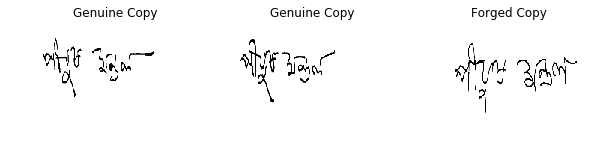

In [16]:
visualize_sample_signature()

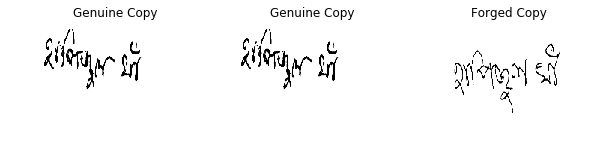

In [17]:
visualize_sample_signature()

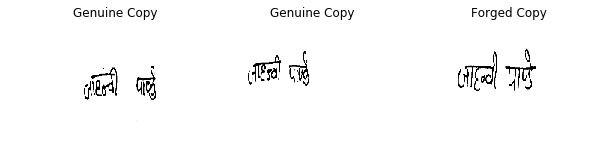

In [18]:
visualize_sample_signature()

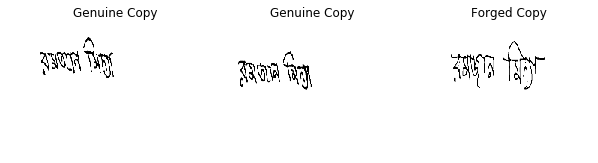

In [19]:
visualize_sample_signature()

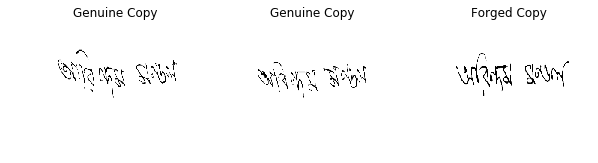

In [20]:
visualize_sample_signature()

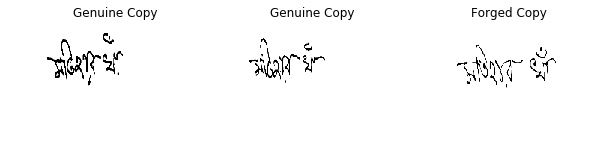

In [21]:
visualize_sample_signature()

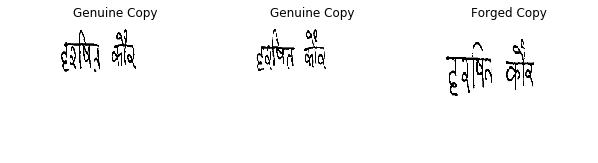

In [22]:
visualize_sample_signature()

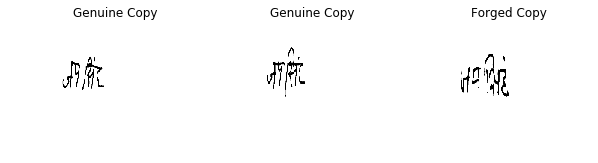

In [23]:
visualize_sample_signature()

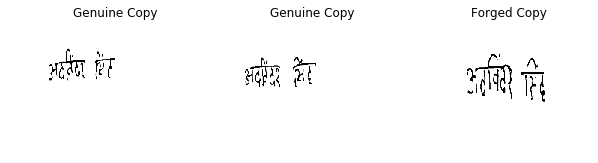

In [24]:
visualize_sample_signature()

##### Generating Batches for training

In [25]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        

        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
 
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

##### Assets for Deep Learning

In [26]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [27]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [28]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

##### The Main Architecture

In [29]:
def create_base_network_signet(input_shape):
    '''Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape ))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(128, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(512, activation='relu'))
    seq.add(Dropout(0.5))
    seq.add(Dense(1))
    
    return seq

In [30]:
input_shape=(img_h, img_w, 1)

In [31]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance, name = 'head_model')
# Specify available GPUs
p_model = multi_gpu_model(model, gpus=4)

In [32]:
batch_sz = 128
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(69120, 11520, 11520)

In [33]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 155, 220, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 155, 220, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 155, 220, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 155, 220, 1)  0           input_2[0][0]                    
____________________________________________________________________________________________

In [34]:
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-bhsig260-full-xavier-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

##### Training

In [38]:

results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/100
540/540 [==============================] - 366s 677ms/step - loss: 1.0636 - val_loss: 0.6605

Epoch 00001: saving model to ./Weights/signet-bhsig260-full-xavier-001.h5
Epoch 2/100
540/540 [==============================] - 244s 452ms/step - loss: 0.2939 - val_loss: 0.2158

Epoch 00002: saving model to ./Weights/signet-bhsig260-full-xavier-002.h5
Epoch 3/100
540/540 [==============================] - 243s 450ms/step - loss: 0.1329 - val_loss: 0.1375

Epoch 00003: saving model to ./Weights/signet-bhsig260-full-xavier-003.h5
Epoch 4/100
540/540 [==============================] - 245s 453ms/step - loss: 0.0813 - val_loss: 0.1466

Epoch 00004: saving model to ./Weights/signet-bhsig260-full-xavier-004.h5
Epoch 5/100
540/540 [==============================] - 244s 451ms/step - loss: 0.0536 - val_loss: 0.1572

Epoch 00005: saving model to ./Weights/signet-bhsig260-full-xavier-005.h5
Epoch 6/100
540/540 [==============================] - 244s 451ms/step - loss: 0.0359 - val_loss: 0.

In [35]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR curves and P-R curves to monitor performance of model on input set.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        
        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        
        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
    if plot_far_frr:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        plt.show()
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [36]:
def load_and_check_model(weight):
    """
    Print validation Accuracy for all saved weights and choose the best for test set
    (TODO - Perform Ensemble of Weights)
    """
    model.load_weights(weight)

    val_gen = generate_batch(orig_val, forg_val, 1)
    pred, tr_y = [], []
    for i in range(num_val_samples):
        (img1, img2), label = next(val_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
    return tr_acc, threshold

#### BHSIG260 full dataset with Xavier Initialisation on Uniform Distribution

In [41]:
acc_thresh = []
for i in range(1,39,1):
    acc_thresh.append(load_and_check_model('./Weights/signet-bhsig260-full-'+str(i).zfill(3)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')

For model 1 Validation Accuracy =  63.37121784596895 %
For model 2 Validation Accuracy =  77.57219553454169 %
For model 3 Validation Accuracy =  81.91654107733535 %
For model 4 Validation Accuracy =  82.03571675575749 %
For model 5 Validation Accuracy =  81.15870561893593 %
For model 6 Validation Accuracy =  82.56760408538459 %
For model 7 Validation Accuracy =  81.17106034302637 %
For model 8 Validation Accuracy =  80.89319586136601 %
For model 9 Validation Accuracy =  82.08091105369888 %
For model 10 Validation Accuracy =  82.93109997075909 %
For model 11 Validation Accuracy =  79.98806480820001 %
For model 12 Validation Accuracy =  79.29754082202507 %
For model 13 Validation Accuracy =  78.39250980829718 %
For model 14 Validation Accuracy =  78.95401315417523 %
For model 15 Validation Accuracy =  79.39519719141322 %
For model 16 Validation Accuracy =  78.53928582614967 %
For model 17 Validation Accuracy =  78.69668965432342 %
For model 18 Validation Accuracy =  79.16482467945352 %
F

#### BHSIG260 full dataset with He Initialisation on Uniform Distribution

In [42]:
acc_thresh = []
for i in range(1,35,1):
    acc_thresh.append(load_and_check_model('./Weights/signet-bhsig260-full-he_init-'+str(i).zfill(3)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')

For model 1 Validation Accuracy =  64.878861003861 %
For model 2 Validation Accuracy =  76.08553189468614 %
For model 3 Validation Accuracy =  78.3735284151073 %
For model 4 Validation Accuracy =  78.37494394727709 %
For model 5 Validation Accuracy =  81.20251051256102 %
For model 6 Validation Accuracy =  78.87007909779273 %
For model 7 Validation Accuracy =  79.76647419758484 %
For model 8 Validation Accuracy =  77.0882853856019 %
For model 9 Validation Accuracy =  78.91857577191332 %
For model 10 Validation Accuracy =  78.23329224522307 %
For model 11 Validation Accuracy =  77.36371760500447 %
For model 12 Validation Accuracy =  78.5569657486166 %
For model 13 Validation Accuracy =  78.30188295165395 %
For model 14 Validation Accuracy =  77.84726660958286 %
For model 15 Validation Accuracy =  77.80805023079287 %
For model 16 Validation Accuracy =  77.81067611160908 %
For model 17 Validation Accuracy =  77.31642350508837 %
For model 18 Validation Accuracy =  77.63206845097844 %
For mo

In [37]:
def test_model(weight):
    model.load_weights(weight)

    test_gen = generate_batch(orig_test, forg_test, 1)
    pred, tr_y = [], []
    for i in range(num_test_samples):
        (img1, img2), label = next(test_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y), plot_far_frr = True)
    return tr_acc, threshold

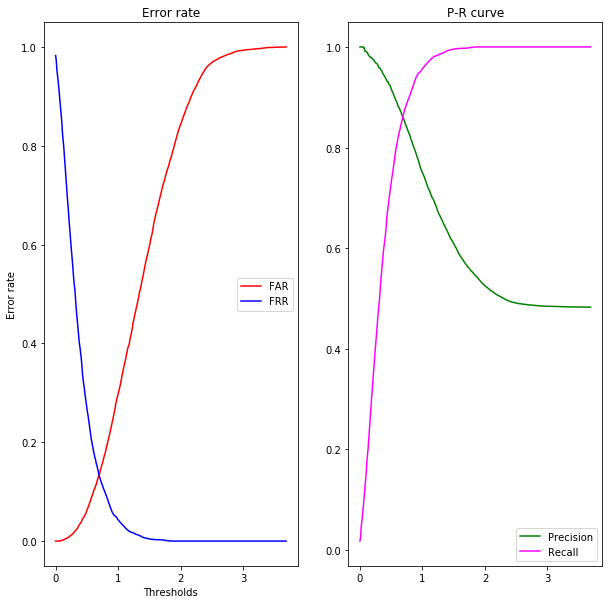

(0.8668020617063397, 0.71)

In [38]:
acc, threshold = test_model('./Weights/signet-bhsig260-full-010.h5')
acc, threshold

#### Accuracy = 86.68% and Threshold = 0.71 Using Xavier Initialisation on Uniform distribution
Thus if the difference score is less than 0.71 we predict the test image as Genuine and if the difference score is greater than 0.71 we predict it to be as forged

#### Below we see some sample results

In [39]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = generate_batch(orig_test, forg_test, 1)
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

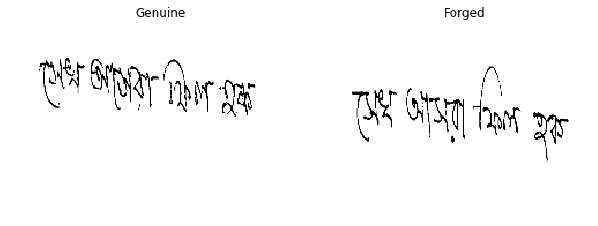

Difference Score =  0.7681368
Its a Forged Signature


In [41]:
predict_score()

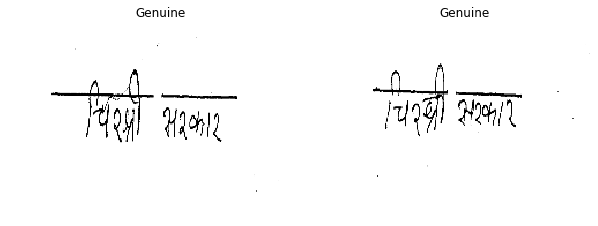

Difference Score =  0.90996814
Its a Forged Signature


In [77]:
predict_score()

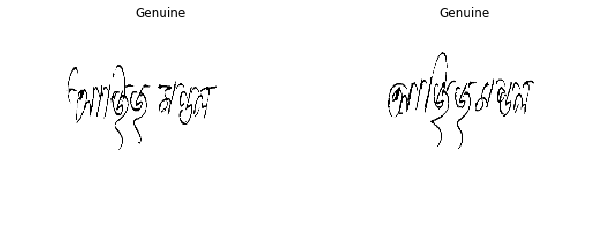

Difference Score =  0.64600396
Its a Genuine Signature


In [78]:
predict_score()

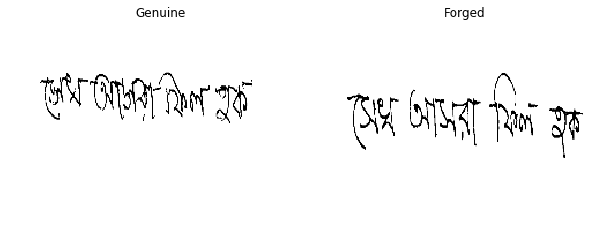

Difference Score =  0.90028965
Its a Forged Signature


In [79]:
predict_score()

In [73]:
gen = "/content/drive/MyDrive/Untitled Folder/161/H-S-161-G-01.tif"
forg = "/content/drive/MyDrive/Untitled Folder/161/H-S-161-F-01.tif"

test_gen1 = generate_bat(gen, forg, 1)

def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen1)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

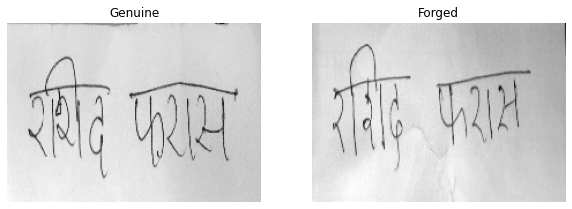

1/1 [==============================] - 0s 18ms/step
Difference Score =  0.7478944
Its a Forged Signature


In [74]:
predict_score()